# Reconnaissance de fleurs


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

L'objectif est de reconnaître un type de fleur sur une image quelconque.
On télécharge une archive qui contient toutes ces images, rangées dans 5 dossiers qui sont nos 5 classes de fleurs différentes.

In [ ]:
url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
dir = tf.keras.utils.get_file("flower_photos", origin=url, untar=True)

228818944/228813984 [==============================] - 13s 0us/step


**Note** : en local, on peut aussi télécharger l'archive et extraire les images nous-même, *à la main*.  
L'archive a été téléchargée et extraite à l'emplacement suivant :

In [ ]:
dir

'/root/.keras/datasets/flower_photos'

- À partir de ces dossiers dans lesquels sont rangées les images, on crée notre dataset d'entraînement et de test (validation). On garde 20% pour le test, le tout est mélangé aléatoirement.  
- On redimensionne toutes les images de sorte qu'elles aient la même taille pour notre modèle, ici **256x256**.  
- Notre modèle n'apprendra pas les images une par une mais plutôt par *paquet* (batch). On regroupe les images par paquet de 32 (`batch_size`).

In [ ]:
train = tf.keras.preprocessing.image_dataset_from_directory(
    dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(256,256),
    batch_size=32
)

class_names = train.class_names

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [ ]:
test = tf.keras.preprocessing.image_dataset_from_directory(
    dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(256,256),
    batch_size=32
)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


Les images ont cependant des pixels de couleurs compris entre 0 et 255. On ramène ces valeurs entre 0 et 1 pour faciliter la tâche à notre modèle.    
Pour ce faire, on appelle une méthode `map` qui applique une fonction à tous nos couples de valeurs `(entrée, sortie)` et qui divise simplement l'entrée par 255. Ici on a recours à cette méthode pour faire notre mise à l'échelle parce que notre dataset est un objet un peu particulier de Keras qui contient les images sous forme de tenseurs.  

**De manière générale**, l'idée est de préparer un ensemble d'images de même taille, dans des tableaux avec des valeurs entre 0 et 1, et des labels associés. Plusieurs moyens existent pour y parvenir !

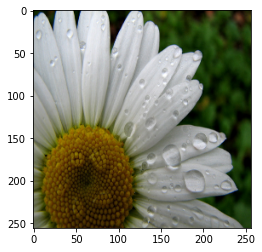

In [ ]:
train = train.map(lambda x, y: (x / 255.0, y))
test = test.map(lambda x, y: (x / 255.0, y))

# petite visualisation, on itère une fois sur notre dataset pour récupérer des images
# (on récupère en fait un batch de 32 images, ainsi que les 32 labels associés)
images, labels = next(iter(train))
plt.imshow(images[0].numpy())

In [ ]:
# optionnel : l'objet de Keras que l'on utilise ici charge en réalité les images
# depuis le disque chaque fois qu'il doit en fournir au modèle. Le chargement peut
# prendre du temps, donc on peut tout charger dans la RAM maintenant pour éviter
# de devoir les charger plus tard.

AUTOTUNE = tf.data.experimental.AUTOTUNE

train = train.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test = test.cache().prefetch(buffer_size=AUTOTUNE)

Notre base de données est prête, il nous reste à définir notre modèle.  
Petits détails sur la première couche de convolution :
 - `16` : nombre de filtres utilisés
 - `3` : nos filtres (noyaux) sont de taille 3x3. On peut aussi écrire `(3,3)` à la place
 - `padding="same"` : on augmente les bords de l'image en copiant leurs valeurs (cf présentation sur les convolutions de tableaux)
 - `activation="relu"` : on utilise la [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) en fonction d'activation
 - `input_shape` : paramètre obligatoire sur la première couche, pour préciser de quelle forme sera notre entrée

In [ ]:
model = tf.keras.Sequential([
      tf.keras.layers.Conv2D(16, 3, padding="same", activation="relu", input_shape=(256,256,3)),
      tf.keras.layers.MaxPool2D(),
      tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu"),
      tf.keras.layers.MaxPool2D(),
      tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu"),
      tf.keras.layers.MaxPool2D(),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128, activation="relu"),
      tf.keras.layers.Dense(5, activation="softmax")
])

# on précise un optimisateur et la fonction d'erreur que l'on choisit
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

On entraîne tout ça  
On donne aussi notre dataset de test, pour que le taux de réussite de notre modèle soit évalué régulièrement.

In [ ]:
model.fit(train, validation_data=test, epochs=8)

Epoch 1/8
92/92 [==============================] - 9s 98ms/step - loss: 1.3105 - accuracy: 0.4629 - val_loss: 1.0438 - val_accuracy: 0.5695
Epoch 2/8
92/92 [==============================] - 6s 68ms/step - loss: 0.9444 - accuracy: 0.6335 - val_loss: 0.9665 - val_accuracy: 0.6213
Epoch 3/8
92/92 [==============================] - 6s 67ms/step - loss: 0.7006 - accuracy: 0.7415 - val_loss: 1.0118 - val_accuracy: 0.5995
Epoch 4/8
92/92 [==============================] - 6s 68ms/step - loss: 0.4479 - accuracy: 0.8396 - val_loss: 1.1454 - val_accuracy: 0.6158
Epoch 5/8
92/92 [==============================] - 6s 68ms/step - loss: 0.2557 - accuracy: 0.9152 - val_loss: 1.3133 - val_accuracy: 0.6267
Epoch 6/8
92/92 [==============================] - 6s 68ms/step - loss: 0.1487 - accuracy: 0.9550 - val_loss: 1.4647 - val_accuracy: 0.6117
Epoch 7/8
92/92 [==============================] - 6s 68ms/step - loss: 0.0757 - accuracy: 0.9758 - val_loss: 2.1466 - val_accuracy: 0.6172
Epoch 8/8
92/92 [===

Notre modèle est entraîné !  
Testons-le sur une nouvelle image, n'importe laquelle sur Internet.  
Il suffit juste de placer notre image quelque part dans les fichiers (icône dossier sur la gauche dans Colab), et c'est parti !

**Note** : le modèle ne prend pas d'image toute seule, mais une liste d'images. De manière générale, les modèles de TensorFlow prennent une liste d'entrées et fournissent une liste de sorties. C'est à ça que sert le `np.array([rose])` : à créer une liste d'une seule image.

In [ ]:
from PIL import Image

rose = Image.open("/content/rose.jpeg")
rose = rose.resize((256,256))
rose = np.array(rose) / 255.0
rose = np.array([rose])

y = model(rose)   # valeurs des 5 neurones de sortie du modèle
i = np.argmax(y)  # on récupère celui qui a la valeur maximale
class_names[i]    # on récupère le nom de la classe associée (type de fleur)

'roses'